In [13]:
import warnings
from typing import Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import scipy.linalg as slin
import scipy.optimize as sopt

from structuremodel import StructureModel
from transformers import DynamicDataTransformer
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 

In [14]:
def from_pandas_dynamic(  # pylint: disable=too-many-arguments
    time_series: Union[pd.DataFrame, List[pd.DataFrame]],
    p: int,
    lambda_w: float = 0.1,
    lambda_a: float = 0.1,
    max_iter: int = 100,
    h_tol: float = 1e-8,
    w_threshold: float = 0.0,
    tabu_edges: List[Tuple[int, int, int]] = None,
    tabu_parent_nodes: List[int] = None,
    tabu_child_nodes: List[int] = None,
) -> StructureModel:
    """
    Learn the graph structure of a Dynamic Bayesian Network describing conditional dependencies between variables in
    data. The input data is a time series or a list of realisations of a same time series.
    The optimisation is to minimise a score function F(W, A) over the graph's contemporaneous (intra-slice) weighted
    adjacency matrix, W, and lagged (inter-slice) weighted adjacency matrix, A, subject to the a constraint function
    h(W), where h_value(W) == 0 characterises an acyclic graph. h(W) > 0 is a continuous, differentiable function that
    encapsulated how acyclic the graph is (less = more acyclic).
    Based on "DYNOTEARS: Structure Learning from Time-Series Data".
    https://arxiv.org/abs/2002.00498
    @inproceedings{pamfil2020dynotears,
        title={DYNOTEARS: Structure Learning from Time-Series Data},
        author={Pamfil, Roxana and Sriwattanaworachai, Nisara and Desai, Shaan and Pilgerstorfer,
        Philip and Georgatzis, Konstantinos and Beaumont, Paul and Aragam, Bryon},
        booktitle={International Conference on Artificial Intelligence and Statistics},
        pages={1595--1605},
        year={2020}year={2020},
    }
    Args:
        time_series: pd.DataFrame or List of pd.DataFrame instances.
        If a list is provided each element of the list being an realisation of a time series (i.e. time series governed
        by the same processes)
        The columns of the data frame represent the variables in the model, and the *index represents the time index*.
        Successive events, therefore, must be indexed with one integer of difference between them too.
        p: Number of past interactions we allow the model to create. The state of a variable at time `t` is affected by
        past variables up to a `t-p`, as well as by other variables at `t`.
        lambda_w: parameter for l1 regularisation of intra-slice edges
        lambda_a: parameter for l1 regularisation of inter-slice edges
        max_iter: max number of dual ascent steps during optimisation.
        h_tol: exit if h(W) < h_tol (as opposed to strict definition of 0).
        w_threshold: fixed threshold for absolute edge weights.
        tabu_edges: list of edges(lag, from, to) not to be included in the graph. `lag == 0` implies that the edge is
        forbidden in the INTRA graph (W), while lag > 0 implies an INTER-slice weight equal zero.
        tabu_parent_nodes: list of nodes banned from being a parent of any other nodes.
        tabu_child_nodes: list of nodes banned from being a child of any other nodes.
    Returns:
        StructureModel representing the model learnt. The node names are noted as `{var}_lag{l}`, where `var` is the
        original variable name as in the give in the input data frames and `l`, in 0,1,2..p is the correspondent
        time lag.
    """
    time_series = [time_series] if not isinstance(time_series, list) else time_series

    X, Xlags = DynamicDataTransformer(p=p).fit_transform(time_series, return_df=False)

    col_idx = {c: i for i, c in enumerate(time_series[0].columns)}
    idx_col = {i: c for c, i in col_idx.items()}

    if tabu_edges:
        tabu_edges = [(lag, col_idx[u], col_idx[v]) for lag, u, v in tabu_edges]
    if tabu_parent_nodes:
        tabu_parent_nodes = [col_idx[n] for n in tabu_parent_nodes]
    if tabu_child_nodes:
        tabu_child_nodes = [col_idx[n] for n in tabu_child_nodes]

    g = from_numpy_dynamic(
        X,
        Xlags,
        lambda_w,
        lambda_a,
        max_iter,
        h_tol,
        w_threshold,
        tabu_edges,
        tabu_parent_nodes,
        tabu_child_nodes,
    )

    sm = StructureModel()
    sm.add_nodes_from(
        [f"{var}_lag{l_val}" for var in col_idx.keys() for l_val in range(p + 1)]
    )
    sm.add_weighted_edges_from(
        [
            (
                _format_name_from_pandas(idx_col, u),
                _format_name_from_pandas(idx_col, v),
                w,
            )
            for u, v, w in g.edges.data("weight")
        ],
        origin="learned",
    )

    return sm


def _format_name_from_pandas(idx_col: Dict[int, str], from_numpy_node: str) -> str:
    """
    Helper function for `from_pandas_dynamic`. converts a node from the `from_numpy_dynamic` format to the `from_pandas`
    format
    Args:
        idx_col: map from variable to intdex
        from_numpy_node: nodes in the structure model output by `from_numpy_dynamic`.
    Returns:
        nodes in from_pandas_dynamic format
    """
    idx, lag_val = from_numpy_node.split("_lag")
    return f"{idx_col[int(idx)]}_lag{lag_val}"


def from_numpy_dynamic(  # pylint: disable=too-many-arguments
    X: np.ndarray,
    Xlags: np.ndarray,
    lambda_w: float = 0.1,
    lambda_a: float = 0.1,
    max_iter: int = 100,
    h_tol: float = 1e-8,
    w_threshold: float = 0.0,
    tabu_edges: List[Tuple[int, int, int]] = None,
    tabu_parent_nodes: List[int] = None,
    tabu_child_nodes: List[int] = None,
) -> StructureModel:
    """
    Learn the graph structure of a Dynamic Bayesian Network describing conditional dependencies between variables in
    data. The input data is time series data present in numpy arrays X and Xlags.
    The optimisation is to minimise a score function F(W, A) over the graph's contemporaneous (intra-slice) weighted
    adjacency matrix, W, and lagged (inter-slice) weighted adjacency matrix, A, subject to the a constraint function
    h(W), where h_value(W) == 0 characterises an acyclic graph. h(W) > 0 is a continuous, differentiable function that
    encapsulated how acyclic the graph is (less = more acyclic).
    Based on "DYNOTEARS: Structure Learning from Time-Series Data".
    https://arxiv.org/abs/2002.00498
    @inproceedings{pamfil2020dynotears,
        title={DYNOTEARS: Structure Learning from Time-Series Data},
        author={Pamfil, Roxana and Sriwattanaworachai, Nisara and Desai, Shaan and Pilgerstorfer,
        Philip and Georgatzis, Konstantinos and Beaumont, Paul and Aragam, Bryon},
        booktitle={International Conference on Artificial Intelligence and Statistics},
        pages={1595--1605},
        year={2020}year={2020},
    }
    Args:
        X (np.ndarray): 2d input data, axis=1 is data columns, axis=0 is data rows. Each column represents one variable,
        and each row represents x(m,t) i.e. the mth time series at time t.
        Xlags (np.ndarray): shifted data of X with lag orders stacking horizontally. Xlags=[shift(X,1)|...|shift(X,p)]
        lambda_w (float): l1 regularization parameter of intra-weights W
        lambda_a (float): l1 regularization parameter of inter-weights A
        max_iter: max number of dual ascent steps during optimisation
        h_tol (float): exit if h(W) < h_tol (as opposed to strict definition of 0)
        w_threshold: fixed threshold for absolute edge weights.
        tabu_edges: list of edges(lag, from, to) not to be included in the graph. `lag == 0` implies that the edge is
        forbidden in the INTRA graph (W), while lag > 0 implies an INTER weight equal zero.
        tabu_parent_nodes: list of nodes banned from being a parent of any other nodes.
        tabu_child_nodes: list of nodes banned from being a child of any other nodes.
    Returns:
        W (np.ndarray): d x d estimated weighted adjacency matrix of intra slices
        A (np.ndarray): d x pd estimated weighted adjacency matrix of inter slices
    Raises:
        ValueError: If X or Xlags does not contain data, or dimensions of X and Xlags do not conform
    """
    _, d_vars = X.shape
    p_orders = Xlags.shape[1] // d_vars

    bnds_w = 2 * [
        (0, 0)
        if i == j
        else (0, 0)
        if tabu_edges is not None and (0, i, j) in tabu_edges
        else (0, 0)
        if tabu_parent_nodes is not None and i in tabu_parent_nodes
        else (0, 0)
        if tabu_child_nodes is not None and j in tabu_child_nodes
        else (0, None)
        for i in range(d_vars)
        for j in range(d_vars)
    ]

    bnds_a = []
    for k in range(1, p_orders + 1):
        bnds_a.extend(
            2
            * [
                (0, 0)
                if tabu_edges is not None and (k, i, j) in tabu_edges
                else (0, 0)
                if tabu_parent_nodes is not None and i in tabu_parent_nodes
                else (0, 0)
                if tabu_child_nodes is not None and j in tabu_child_nodes
                else (0, None)
                for i in range(d_vars)
                for j in range(d_vars)
            ]
        )

    bnds = bnds_w + bnds_a
    w_est, a_est = _learn_dynamic_structure(
        X, Xlags, bnds, lambda_w, lambda_a, max_iter, h_tol
    )

    w_est[np.abs(w_est) < w_threshold] = 0
    a_est[np.abs(a_est) < w_threshold] = 0
    #sm = _matrices_to_structure_model(w_est, a_est)
    #return sm
    return w_est, a_est


def _matrices_to_structure_model(
    w_est: np.ndarray, a_est: np.ndarray
) -> StructureModel:
    """
    Converts the matrices output by dynotears (W and A) into a StructureModel
    We use the following convention:
    - {var}_lag{l} where l is the lag value (i.e. from how many previous timestamps the edge is coming
    - if we deal with a intra_slice_node, `l == 0`
    Args:
        w_est: Intra-slice weight matrix
        a_est: Inter-slice matrix
    Returns:
        StructureModel representing the structure learnt
    """
    sm = StructureModel()
    lag_cols = [
        f"{var}_lag{l_val}"
        for l_val in range(1 + (a_est.shape[0] // a_est.shape[1]))
        for var in range(a_est.shape[1])
    ]
    sm.add_nodes_from(lag_cols)
    sm.add_edges_from(
        [
            (lag_cols[i], lag_cols[j], dict(weight=w_est[i, j]))
            for i in range(w_est.shape[0])
            for j in range(w_est.shape[1])
            if w_est[i, j] != 0
        ]
    )
    sm.add_edges_from(
        [
            (lag_cols[i + w_est.shape[0]], lag_cols[j], dict(weight=a_est[i, j]))
            for i in range(a_est.shape[0])
            for j in range(a_est.shape[1])
            if a_est[i, j] != 0
        ]
    )
    return sm


def _reshape_wa(
    wa_vec: np.ndarray, d_vars: int, p_orders: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Helper function for `_learn_dynamic_structure`. Transform adjacency vector to matrix form
    Args:
        wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights
        d_vars (int): number of variables in the model
        p_orders (int): number of past indexes we to use
    Returns:
        intra- and inter-slice adjacency matrices
    """

    w_tilde = wa_vec.reshape([2 * (p_orders + 1) * d_vars, d_vars])
    w_plus = w_tilde[:d_vars, :]
    w_minus = w_tilde[d_vars : 2 * d_vars, :]
    w_mat = w_plus - w_minus
    a_plus = (
        w_tilde[2 * d_vars :]
        .reshape(2 * p_orders, d_vars**2)[::2]
        .reshape(d_vars * p_orders, d_vars)
    )
    a_minus = (
        w_tilde[2 * d_vars :]
        .reshape(2 * p_orders, d_vars**2)[1::2]
        .reshape(d_vars * p_orders, d_vars)
    )
    a_mat = a_plus - a_minus
    return w_mat, a_mat


def _learn_dynamic_structure(
    X: np.ndarray,
    Xlags: np.ndarray,
    bnds: List[Tuple[float, float]],
    lambda_w: float = 0.1,
    lambda_a: float = 0.1,
    max_iter: int = 100,
    h_tol: float = 1e-8,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Learn the graph structure of a Dynamic Bayesian Network describing conditional dependencies between data variables.
    The optimisation is to minimise a score function F(W, A) over the graph's contemporaneous (intra-slice) weighted
    adjacency matrix, W, and lagged (inter-slice) weighted adjacency matrix, A, subject to the a constraint function
    h(W), where h_value(W) == 0 characterises an acyclic graph. h(W) > 0 is a continuous, differentiable function that
    encapsulated how acyclic the graph is (less = more acyclic).
    Based on "DYNOTEARS: Structure Learning from Time-Series Data".
    https://arxiv.org/abs/2002.00498
    @inproceedings{pamfil2020dynotears,
        title={DYNOTEARS: Structure Learning from Time-Series Data},
        author={Pamfil, Roxana and Sriwattanaworachai, Nisara and Desai, Shaan and Pilgerstorfer,
        Philip and Georgatzis, Konstantinos and Beaumont, Paul and Aragam, Bryon},
        booktitle={International Conference on Artificial Intelligence and Statistics},
        pages={1595--1605},
        year={2020}year={2020},
    }
    Args:
        X (np.ndarray): 2d input data, axis=1 is data columns, axis=0 is data rows. Each column represents one variable,
        and each row represents x(m,t) i.e. the mth time series at time t.
        Xlags (np.ndarray): shifted data of X with lag orders stacking horizontally. Xlags=[shift(X,1)|...|shift(X,p)]
        bnds: Box constraints of L-BFGS-B to ban self-loops in W, enforce non-negativity of w_plus, w_minus, a_plus,
        a_minus, and help with stationarity in A
        lambda_w (float): l1 regularization parameter of intra-weights W
        lambda_a (float): l1 regularization parameter of inter-weights A
        max_iter (int): max number of dual ascent steps during optimisation
        h_tol (float): exit if h(W) < h_tol (as opposed to strict definition of 0)
    Returns:
        W (np.ndarray): d x d estimated weighted adjacency matrix of intra slices
        A (np.ndarray): d x pd estimated weighted adjacency matrix of inter slices
    Raises:
        ValueError: If X or Xlags does not contain data, or dimensions of X and Xlags do not conform
    """
    if X.size == 0:
        raise ValueError("Input data X is empty, cannot learn any structure")
    if Xlags.size == 0:
        raise ValueError("Input data Xlags is empty, cannot learn any structure")
    if X.shape[0] != Xlags.shape[0]:
        raise ValueError("Input data X and Xlags must have the same number of rows")
    if Xlags.shape[1] % X.shape[1] != 0:
        raise ValueError(
            "Number of columns of Xlags must be a multiple of number of columns of X"
        )

    n, d_vars = X.shape
    p_orders = Xlags.shape[1] // d_vars

    def _h(wa_vec: np.ndarray) -> float:
        """
        Constraint function of the dynotears
        Args:
            wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights
        Returns:
            float: DAGness of the intra-slice adjacency matrix W (0 == DAG, >0 == cyclic)
        """

        _w_mat, _ = _reshape_wa(wa_vec, d_vars, p_orders)
        return np.trace(slin.expm(_w_mat * _w_mat)) - d_vars

    def _func(wa_vec: np.ndarray) -> float:
        """
        Objective function that the dynotears tries to minimise
        Args:
            wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights
        Returns:
            float: objective
        """

        _w_mat, _a_mat = _reshape_wa(wa_vec, d_vars, p_orders)
        loss = (
            0.5
            / n
            * np.square(
                np.linalg.norm(
                    X.dot(np.eye(d_vars, d_vars) - _w_mat) - Xlags.dot(_a_mat), "fro"
                )
            )
        )
        _h_value = _h(wa_vec)
        l1_penalty = lambda_w * (wa_vec[: 2 * d_vars**2].sum()) + lambda_a * (
            wa_vec[2 * d_vars**2 :].sum()
        )
        return loss + 0.5 * rho * _h_value * _h_value + alpha * _h_value + l1_penalty

    def _grad(wa_vec: np.ndarray) -> np.ndarray:
        """
        Gradient function used to compute next step in dynotears
        Args:
            wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights
        Returns:
            gradient vector
        """

        _w_mat, _a_mat = _reshape_wa(wa_vec, d_vars, p_orders)
        e_mat = slin.expm(_w_mat * _w_mat)
        loss_grad_w = (
            -1.0
            / n
            * (X.T.dot(X.dot(np.eye(d_vars, d_vars) - _w_mat) - Xlags.dot(_a_mat)))
        )
        obj_grad_w = (
            loss_grad_w
            + (rho * (np.trace(e_mat) - d_vars) + alpha) * e_mat.T * _w_mat * 2
        )
        obj_grad_a = (
            -1.0
            / n
            * (Xlags.T.dot(X.dot(np.eye(d_vars, d_vars) - _w_mat) - Xlags.dot(_a_mat)))
        )

        grad_vec_w = np.append(
            obj_grad_w, -obj_grad_w, axis=0
        ).flatten() + lambda_w * np.ones(2 * d_vars**2)
        grad_vec_a = obj_grad_a.reshape(p_orders, d_vars**2)
        grad_vec_a = np.hstack(
            (grad_vec_a, -grad_vec_a)
        ).flatten() + lambda_a * np.ones(2 * p_orders * d_vars**2)
        return np.append(grad_vec_w, grad_vec_a, axis=0)

    # initialise matrix, weights and constraints
    wa_est = np.zeros(2 * (p_orders + 1) * d_vars**2)
    wa_new = np.zeros(2 * (p_orders + 1) * d_vars**2)
    rho, alpha, h_value, h_new = 1.0, 0.0, np.inf, np.inf

    for n_iter in range(max_iter):
        while (rho < 1e20) and (h_new > 0.25 * h_value or h_new == np.inf):
            wa_new = sopt.minimize(
                _func, wa_est, method="L-BFGS-B", jac=_grad, bounds=bnds
            ).x
            h_new = _h(wa_new)
            if h_new > 0.25 * h_value:
                rho *= 10

        wa_est = wa_new
        h_value = h_new
        alpha += rho * h_value
        if h_value <= h_tol:
            break
        if h_value > h_tol and n_iter == max_iter - 1:
            warnings.warn("Failed to converge. Consider increasing max_iter.")
    return _reshape_wa(wa_est, d_vars, p_orders)

In [15]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from statistics import mean
import random

In [16]:
def simulate_lsem_dynamic(W_all,Z: nx.DiGraph,
                 n: int,n_time:int, treatment_type: str,
                 noise_scale: float = 0.5,
                 baseline: float = 1.0) -> np.ndarray:
    """Simulate samples from LSEM.
        
        Args:
        W_all,A: weigthed DAG for instaneous relation and lagged relation
        n: number of samples in each time-stamp
        lag: degree of AR
        n_time: number of time stamp
        treatment_type: the type of the exposure {Binary, Gaussian}
        noise_scale: noise scale parameter of Gaussian distribution in the lSEM
        baseline: the baseline for the outcome
        
        Returns:
        X: [time,n, d] sample matrix
        """
    #W_array = nx.to_numpy_array(W)
    Z_array = nx.to_numpy_array(Z)
    d = Z_array.shape[0]
    #X_all = np.zeros([n_time+1,n, d])
    
    ## create the initial data
    X = np.zeros([n, d])
    W_0=W_all[0,:,:]
    ordered_vertices = list(nx.topological_sort(nx.from_numpy_matrix(W_0,create_using=nx.DiGraph)))
    assert len(ordered_vertices) == d
    rank_A = ordered_vertices.index(0)
    for j in ordered_vertices:
        if ordered_vertices.index(j) > rank_A:
            parents = list(nx.from_numpy_matrix(W_0,create_using=nx.DiGraph).predecessors(j))
            X[:, j] = X[:, parents].dot(W_0[parents, j]) + np.random.normal(scale=noise_scale, size=n)
        elif ordered_vertices.index(j) < rank_A:
            X[:, j] = np.random.normal(scale=noise_scale, size=n)
        else:
            if treatment_type == 'Binary':
                X[:, j] = 2 * (np.random.binomial(1, 0.5, n) - 0.5)
            elif treatment_type == 'Gaussian':
                X[:, j] = np.random.normal(scale=noise_scale, size=n)
            else:
                raise ValueError('unknown exposure type')
    X[:, d-1] += baseline
    X_all=X
    ## for follow-up time-stamps, X=XW+AZ+E
    for time in range(1,n_time+1):
        X_temp = np.matmul(X,Z_array)
        W_array=W_all[time,:,:] ## different index!
        W=nx.from_numpy_matrix(W_array,create_using=nx.DiGraph)
        for j in ordered_vertices:
            if ordered_vertices.index(j) > rank_A:
                parents = list(W.predecessors(j))
                X_temp[:, j] += X_temp[:, parents].dot(W_array[parents, j]) + np.random.normal(scale=noise_scale, size=n)
            elif ordered_vertices.index(j) < rank_A:
                X_temp[:, j] += np.random.normal(scale=noise_scale, size=n)
            else:
                if treatment_type == 'Binary':
                    X_temp[:, j] += 2 * (np.random.binomial(1, 0.5, n) - 0.5)
                elif treatment_type == 'Gaussian':
                    X_temp[:, j] += np.random.normal(scale=noise_scale, size=n)
                else:
                    raise ValueError('unknown exposure type')
        X_all=np.append(X_all,X_temp,axis=0)
        X=X_temp
    return X_all

In [17]:
W_all=np.zeros([11,5, 5])
import math 
#def cos(x):
#    return(-10+(5-x)**2)/20
import math 
def cos(x):
    return math.cos(x/4*math.pi)*0.8
for i in range(11):
    W_all[i,0,4]=cos(i)

In [18]:
## create Z matrix
Z=np.zeros((5,5))
#Z[0,0]=0 # no correlation for treatment
Z_graph=nx.from_numpy_matrix(Z,create_using=nx.DiGraph)

In [19]:
p_orders=1
d_vars=5
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
w_list=np.zeros((n_times,time_stamp,n_var, n_var))
a_list=np.zeros((n_times,time_stamp,n_var, n_var))
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=simulate_lsem_dynamic(W_all,Z_graph,30,10, 'Binary',noise_scale=0.1)
  for time in range(time_stamp):
    X=X_all[(time+1)*30:(time+2)*30]
    Y=X_all[(time)*30:(time+1)*30]
    w,a=from_numpy_dynamic(X,Y)
    w_list[replicate,time,:,:]=w
    a_list[replicate,time,:,:]=a
    #np.save("result/dynotears_quadratic_w_noA",w_list)
    #np.save("result/dynotears_quadratic_a_noA",a_list)
    np.save("result/dynotears_cos_w_noA",w_list)
    np.save("result/dynotears_cosa_noA",a_list)
  print(replicate)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [11]:
result_dynotears=np.load("result/dynotears_quadratic_w_noA.npy")

Text(0, 0.5, 'Causal strength')

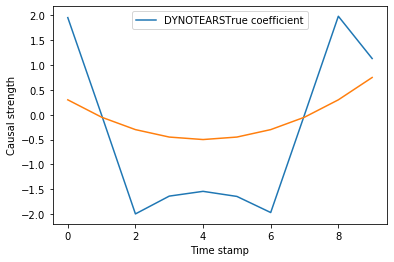

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
import numpy as np
fig, ax=plt.subplots(1)
d=pd.DataFrame({'a':result_dynotears.mean(axis=0)[:,4,0],
               # 'b':exten_matrix.mean(axis=0)[:,0,4],
                'c':[cos(i+1) for i in range(time_stamp)]
               })
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_prop_cycle(cycler('color', colors[:4]))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(d)
plt.legend(["DYNOTEARS" "True coefficient",])
  
# function to show the plot
plt.xlabel("Time stamp")
plt.ylabel("Causal strength")

## scenario 2

In [22]:
np.random.seed(1234567)
def simulate_random_dag(d: int,
                        degree: float,
                        w_range: tuple = (1.0, 1.0)) -> nx.DiGraph:
    """Simulate random DAG with an expected degree by Erdos-Renyi model.
        
        Args:
        d: number of nodes
        degree: expected node degree, in + out
        w_range: weight range +/- (low, high)
        
        Returns:
        G: weighted DAG
        """
    prob = float(degree) / (d - 1)
    B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
    
    # random permutation
    P = np.random.permutation(np.eye(d, d))  # permutes first axis only
    B_perm = P.T.dot(B).dot(P)
    U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
    U[np.random.rand(d, d) < 0.5] *= -1
    W = (B_perm != 0).astype(float) * U
    
    # remove all in-edges (from precedent nodes) of the first node as A
    W[:, 0] = 0
    # remove all out-edges (from descendent nodes) of the last node as Y
    W[d-1, :] = 0
    # the remained nodes are the mediators M; and reset mediators if it has higher topological order than A or lower order than Y.
    ordered_vertices = list(nx.topological_sort(nx.DiGraph(W)))
    j = 1
    while j < d - 1:
        if  ordered_vertices.index(j) < ordered_vertices.index(0):
            W[j, 1:(d - 1)] = np.zeros (d - 2)
        if  ordered_vertices.index(j) > ordered_vertices.index(d - 1):
            W[1:(d - 1), j] = np.zeros (d - 2)
        j = j + 1
    #print("True weighted adjacency matrix B:\n", W)
    G = nx.DiGraph(W)
    #calculate_effect(W)
    return W

In [23]:
np.random.seed(123456)
base_DAG=simulate_random_dag(5,4)
base_DAG

array([[ 0., -1., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0., -0.],
       [ 0.,  1., -0.,  0.,  1.],
       [ 0., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [24]:
random.seed(1234567)
pick_element=random.sample(range(5), 2) ## pick two location to mutate
pick_1=np.nonzero(base_DAG)[0][pick_element[0]],np.nonzero(base_DAG)[1][pick_element[0]]
pick_2=np.nonzero(base_DAG)[0][pick_element[1]],np.nonzero(base_DAG)[1][pick_element[1]]

In [25]:
import math 
def cos(x):
    return ((math.cos(x/6*math.pi))/4+1)*0.8
def quadratic(x):
    return(-5+(10-x)**2)/200+0.5

In [26]:
def data_create(seed,time_stamp,set_graph):
  np.random.seed(seed)
  x = np.array(range(0, time_stamp))
  #y = np.array([cos(i)+np.random.normal(0, 0.1, 1) for i in x]) #generate coefficient
  y=np.array([cos(i) for i in x])
  z=np.array([quadratic(i) for i in x])##edited to have multiple
  base_DAG=set_graph 
  base_DAG[pick_1]=y[0]##edited to be coeffcient with error
  base_DAG[pick_2]=z[0]###multiple
  base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
  X_all = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
  for i in range(1,time_stamp):
      base_DAG[pick_1]=y[i]##edited to be coeffcient with error
      base_DAG[pick_2]=z[i]###multiple
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      X = simulate_lsem(base_graph,30, 'Binary', 1,noise_scale=0.1)
      X_all=np.append(X_all,X,axis=0)
      print(base_DAG)
  return X_all

In [28]:
def simulate_lsem(G: nx.DiGraph,
                 n: int, A_type: str,
                 x_dims: int = 1,
                 noise_scale: float = 0.5,
                 baseline: float = 1.0) -> np.ndarray:
    """Simulate samples from LSEM.
        
        Args:
        G: weigthed DAG
        n: number of samples
        A_type: the type of the exposure {Binary, Gaussian}
        x_dims: dimension of each node
        noise_scale: noise scale parameter of Gaussian distribution in the lSEM
        baseline: the baseline for the outcome
        
        Returns:
        X: [n, d] sample matrix
        """
    W = nx.to_numpy_array(G)
    d = W.shape[0]
    X = np.zeros([n, d, x_dims])
    ordered_vertices = list(nx.topological_sort(G))
    assert len(ordered_vertices) == d
    rank_A = ordered_vertices.index(0)
    for j in ordered_vertices:
        if ordered_vertices.index(j) > rank_A:
            parents = list(G.predecessors(j))
            X[:, j, 0] = X[:, parents, 0].dot(W[parents, j]) + np.random.normal(scale=noise_scale, size=n)
        elif ordered_vertices.index(j) < rank_A:
            X[:, j, 0] = np.random.normal(scale=noise_scale, size=n)
        else:
            if A_type == 'Binary':
                X[:, j, 0] = 2 * (np.random.binomial(1, 0.5, n) - 0.5)
            elif A_type == 'Gaussian':
                X[:, j, 0] = np.random.normal(scale=noise_scale, size=n)
            else:
                raise ValueError('unknown exposure type')
    X[:, d-1, 0] += baseline
    return X

In [34]:
X.shape

(30, 5, 1)

In [35]:
p_orders=1
d_vars=5
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
w_list=np.zeros((n_times,time_stamp,n_var, n_var))
a_list=np.zeros((n_times,time_stamp,n_var, n_var))
for replicate in range(n_times):
  seed=seed_list[replicate]
  X_all=data_create(seed,time_stamp,base_DAG) #create data
  for time in range(time_stamp-1):
    X=X_all[(time+1)*30:(time+2)*30].reshape(30,5)
    Y=X_all[(time)*30:(time+1)*30].reshape(30,5)
    w,a=from_numpy_dynamic(X,Y)
    w_list[replicate,time,:,:]=w
    a_list[replicate,time,:,:]=a
    #np.save("result/dynotears_quadratic_w_noA",w_list)
    #np.save("result/dynotears_quadratic_a_noA",a_list)
    np.save("result/dynotears_full_w_noA",w_list)
    np.save("result/dynotears_full_noA",a_list)
  print(replicate)


[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.     

4
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.   

9
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.   

14
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.  

19
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.  

24
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.  

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:1698: RuntimeWarning: invalid value encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)


25
[[ 0.         -1.         -0.          0.88        0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.          1.         -0.          0.          0.97320508]
 [ 0.         -0.          0.          0.         -0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[ 0.    -1.    -0.     0.795  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.9  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.   -1.   -0.    0.72  0.  ]
 [ 0.    0.    0.    0.   -0.  ]
 [ 0.    1.   -0.    0.    0.8 ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[ 0.    -1.    -0.     0.655  0.   ]
 [ 0.     0.     0.     0.    -0.   ]
 [ 0.     1.    -0.     0.     0.7  ]
 [ 0.    -0.     0.     0.    -0.   ]
 [ 0.     0.     0.     0.     0.   ]]
[[ 0.         -1.         -0.          0.6         0.        ]
 [ 0.          0.          0.          0.         -0.        ]
 [ 0.  